### Check precomputed similar images in HBase

In [1]:
import happybase as hb
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
conf_fn = '../conf/global_var_remotehbase.json'
sha1 = "000003E6B7BB74F43D61BCA2777A889AA41377B5"

In [7]:
conf = json.load(open(conf_fn, 'rt'))
tab_sim_name = 'escorts_images_similar_row_dev_Y2017W15'

In [9]:
def get_all_similar_sha1s(sha1, conf, tab_sim_name=None):
    conn = hb.Connection(conf['HBI_host'])
    if tab_sim_name is None:
        tab_sim = conn.table(conf['HBI_table_sim'])
    else:
        tab_sim = conn.table(tab_sim_name)
    row = tab_sim.row(sha1)
    print row
    similar_images = []
    for sim_img in row:
        similar_images.append((sim_img.split(':')[-1], row[sim_img]))
    return similar_images

In [10]:
def get_s3urls_sha1s(sha1s, conf):
    conn = hb.Connection(conf['HBI_host'])
    tab_sha1 = conn.table(conf['HBI_table_sha1infos'])
    rows = tab_sha1.rows(sha1s)
    image_list = []
    for row in rows:
        image_list.append((row[0], row[1]['info:s3_url']))
    return image_list

In [11]:
def dl_image(s3_url):
    # download with boto, read from bytes to PIL image
    import boto3
    import cStringIO
    from PIL import Image
    s3_res = boto3.resource('s3')
    s3_clt = boto3.client('s3')
    try:
        s3_spl = s3_url.split("/")
        try:
          bucket_pos = s3_spl.index('s3.amazonaws.com')+1
        except:
          print "{} is not a s3 url.".format(s3_url)
          return None
        bucket = s3_spl[bucket_pos]
        key = '/'.join(s3_spl[bucket_pos+1:])
        buffer = cStringIO.StringIO()
        s3_clt.download_fileobj(bucket, key, buffer)
        img = Image.open(buffer)
        # # for debugging
        # s3_img_obj = s3_res.Object(bucket, key)
        # ctype = s3_img_obj.content_type
        # nb_bytes = s3_img_obj.content_length
        # #print bucket, key, ctype, nb_bytes, img.size
        return img
    except Exception as err:
        print "Could not download image from {}. Error was: {}".format(s3_url, err)
        return None

In [22]:
def disp_image_list(image_list):
    from IPython.display import display
    imgs = []
    for img_sha1,s3_url in image_list:
        imgs.append(dl_image(str(s3_url)))
    display(*imgs)

### Run things

In [27]:
similar_sha1s = get_all_similar_sha1s(sha1, conf, tab_sim_name)
print similar_sha1s
similar_sha1s_only = [x[0] for x in similar_sha1s]

{'s:2D9E2857C8DBC4EB8D38058E1F6DBE85BCE3176C': '0.0630588', 's:7D71D573FFDB52D414E8F99FF7BC7D754D88163E': '0.0631007', 's:68FEE3949C234643F5F8E699ACCBD17848F814CC': '0.00028078', 's:CDE03795DC2AA55E744553F2713D64BB50CCAF36': '0.0272493', 's:D5DA2AA8679CF231F473165ED1D4E8D80C1C59C2': '0.0280975', 's:E92F8EBCCF381548AE64DDF0DD40AC8DACC01F13': '1.24509e-07', 's:BD0677040B4BA747C79BE03CA6A7B4ABF064F3D6': '4.24972e-13', 's:000003E6B7BB74F43D61BCA2777A889AA41377B5': '2.77111e-14', 's:4B7917A0B54A33E987354AB9F7C01C929323E4B2': '0.000262365', 's:207BC0E04648C50072F39AF669364345BFE01BE2': '0.000273537', 's:34AD74FD3C321C5FB02047540E368574F7063EA0': '0.0023628', 's:2E8DE5FCA4A709B959985CADB3AB78719D73D652': '0.0315278', 's:3E8B169A12F0662D369DCC62452B69B46C6F818A': '0.0280384', 's:89D1B9BD82D59BF87D83C0CAD3C21140A2B5CDF3': '0.000273537', 's:CE6BF694EAD164C979B337E3CB7769FABCE6F19C': '0.000273537', 's:F37D21B9F255CA5E53074253B456B8F05D33F29B': '0.000273537', 's:E7660C46B0CF13372AA77B39FABCBD8C7D3

In [30]:
image_list = get_s3urls_sha1s(similar_sha1s_only, conf)
print image_list

[('2D9E2857C8DBC4EB8D38058E1F6DBE85BCE3176C', 'https://s3.amazonaws.com/roxyimages/76b8309912076f0e58ff6f112f0011692b10036e.jpg'), ('7D71D573FFDB52D414E8F99FF7BC7D754D88163E', 'https://s3.amazonaws.com/roxyimages/b08d81e705fd587b0a48e1d448b115d9e0270b99.jpg'), ('68FEE3949C234643F5F8E699ACCBD17848F814CC', 'https://s3.amazonaws.com/roxyimages/ba191611296c7edd52feded2eccabf5fa7e1fccd.jpg'), ('CDE03795DC2AA55E744553F2713D64BB50CCAF36', 'https://s3.amazonaws.com/roxyimages/f286fea45474786dac6bf256831cf1c3997cf8f8.jpg'), ('D5DA2AA8679CF231F473165ED1D4E8D80C1C59C2', 'https://s3.amazonaws.com/roxyimages/642941d84fb300f8b2c4f6a6977507c2049cf6f9.jpg'), ('E92F8EBCCF381548AE64DDF0DD40AC8DACC01F13', 'https://s3.amazonaws.com/roxyimages/cae6dc5d647ea35ebfe69f1b44e242ebe96d4e16.jpg'), ('BD0677040B4BA747C79BE03CA6A7B4ABF064F3D6', 'https://s3.amazonaws.com/roxyimages/66f04880be988bd0542c097c698d6aa4fffb28bf.jpg'), ('000003E6B7BB74F43D61BCA2777A889AA41377B5', 'https://s3.amazonaws.com/roxyimages/1b15051

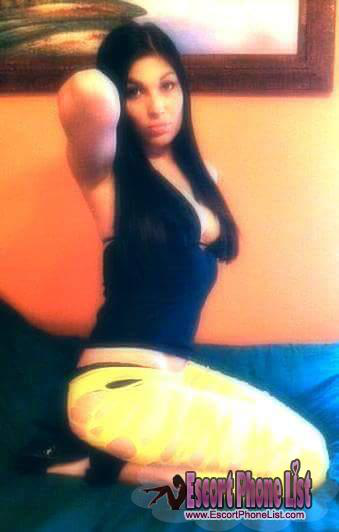

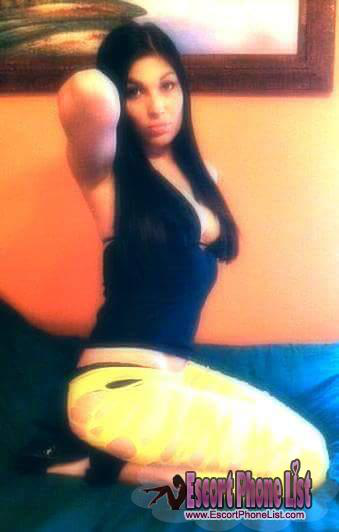

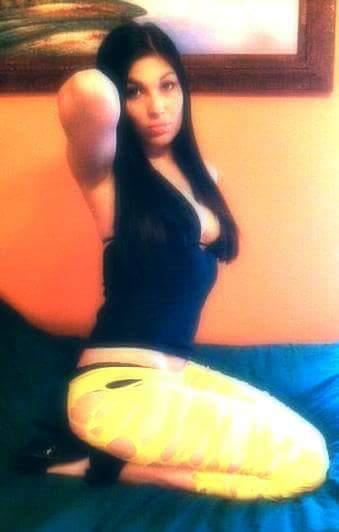

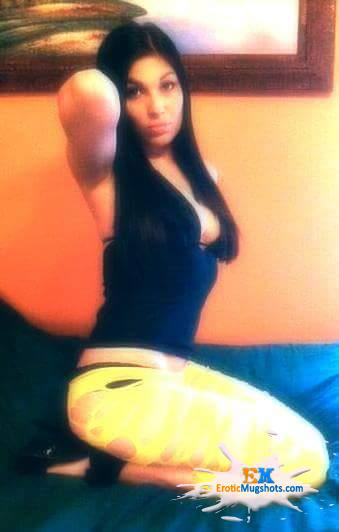

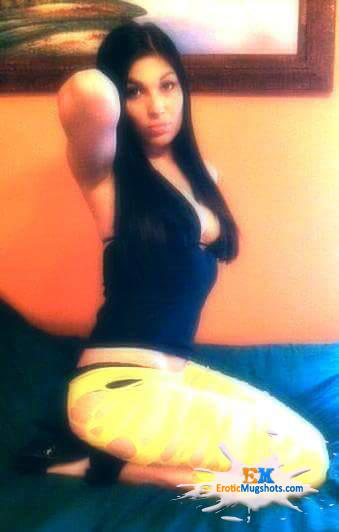

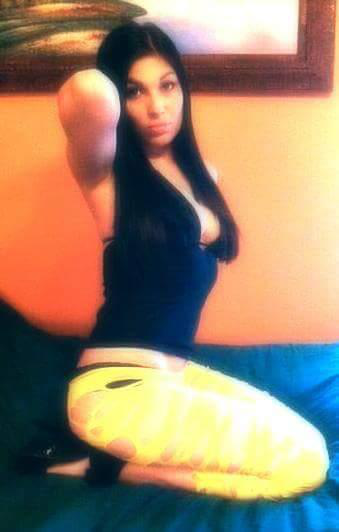

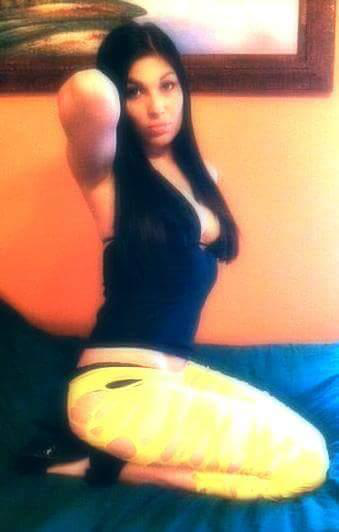

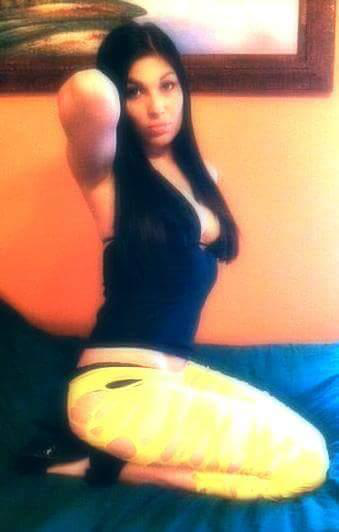

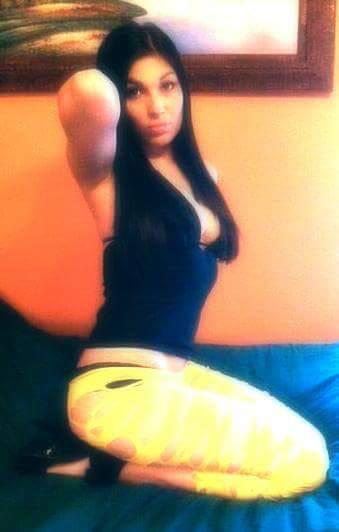

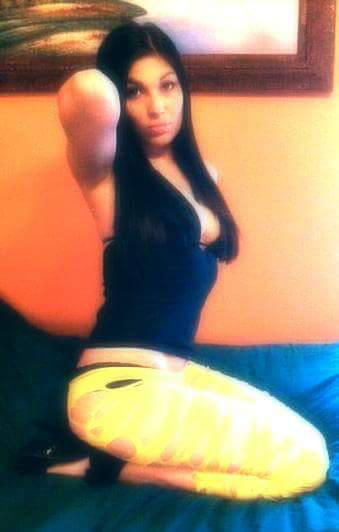

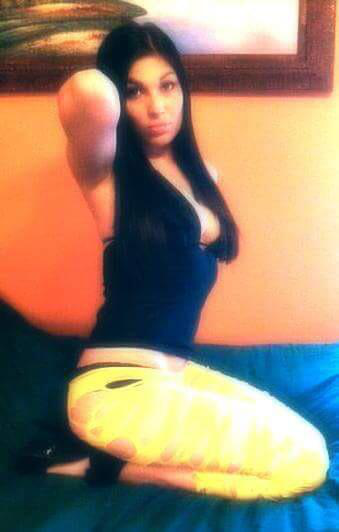

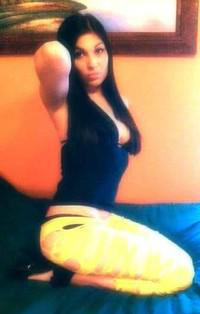

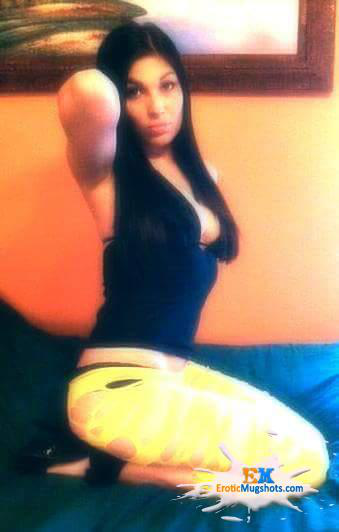

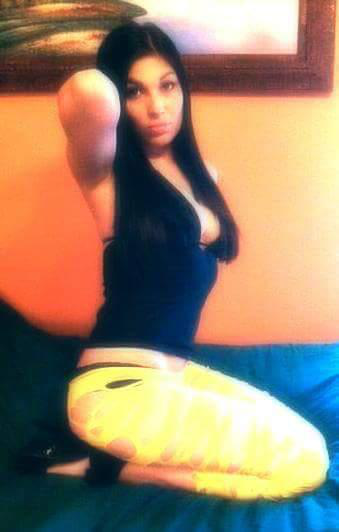

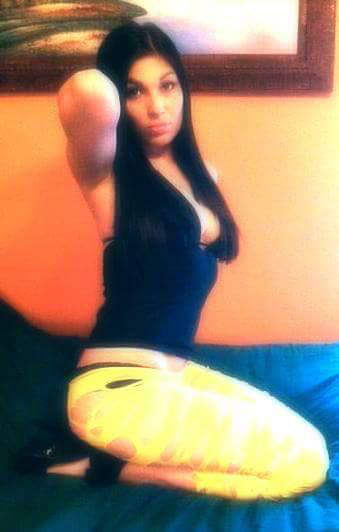

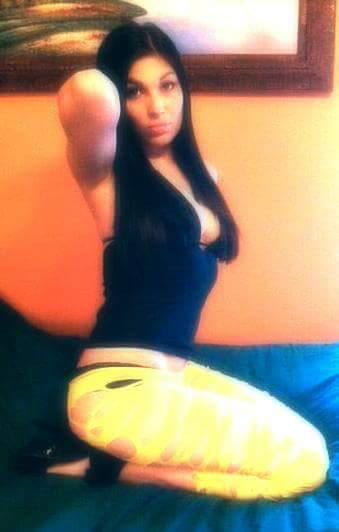

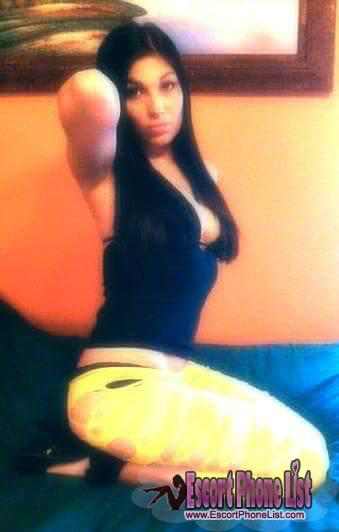

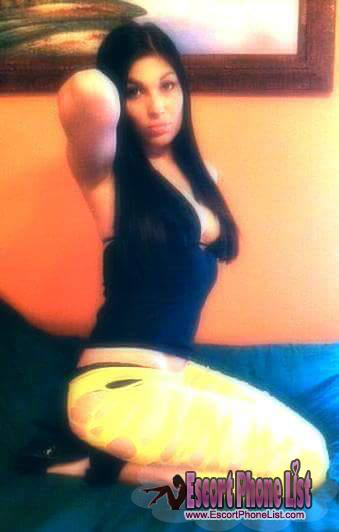

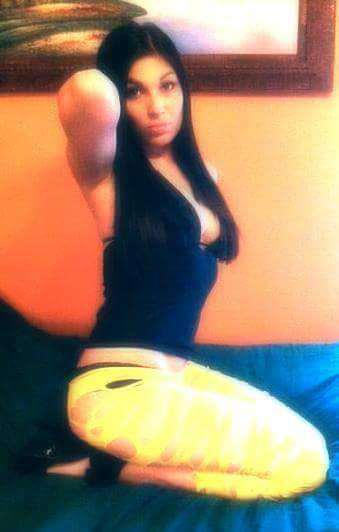

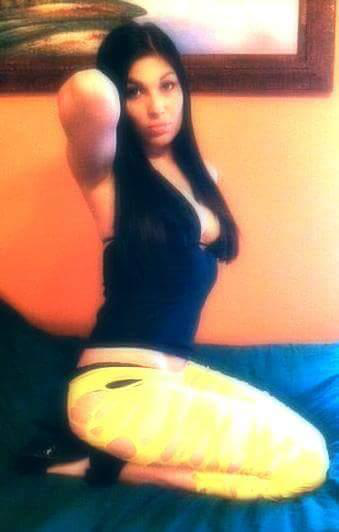

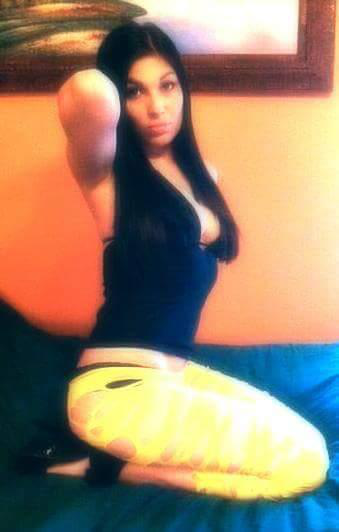

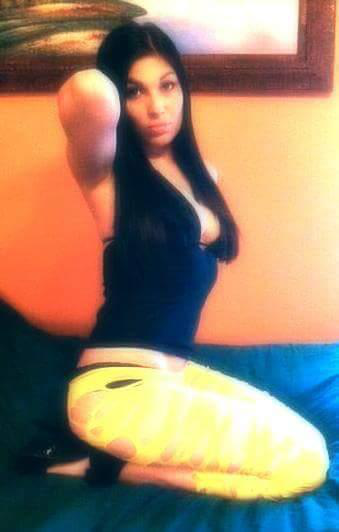

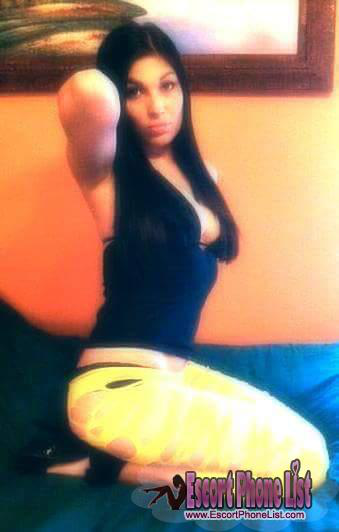

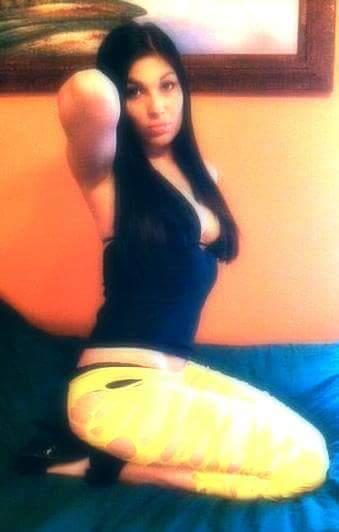

In [31]:
# similar images
disp_image_list(image_list)

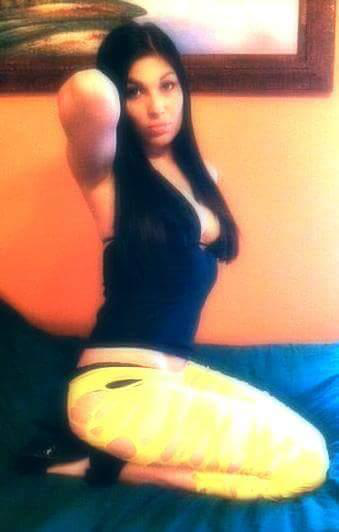

In [29]:
# query
disp_image_list(get_s3urls_sha1s([sha1], conf))